# Decision theory

The purpose of this notebook is to provide some illustrations on optimal classification for a 1-dimensional Gaussian Mixture Model. By Jakob Drefs.

In the following we will visualize for each class the conditional and joint probabilities $p(x\vert c,\Theta)$ and $p(x,c\vert\Theta)$ together with the decision regions $R_{c}$. The user can interactively adjust the number of classes $C$ and the model parameters $\mu_{c},\sigma_{c}^2, \pi_{c}$ for a single class $c_0$. Parameters of further classes will be set automatically based on some heuristically chosen values. 

The definition of decision regions for optimal classification was introduced in the lecture as

\begin{equation}
R_i=\{x\in\mathcal{Data}~|~p(c=\mathcal{C}_i|x,\Theta)>p(c=\mathcal{C}_j|x,\Theta)~\forall j\neq i\}
\end{equation}

In order to illustrate $R_{i}$, posterior probabilities for each class given the data need to be computed. We will do this step by step. The implementation avoids loops by employing broadcasting and vectorization.

In [1]:
import numpy as np

def p_x_c(x, mu, sigma) :
    """
    Computes the class-conditional probabiliy p(x|c,Theta) using a Gaussian pdf. 
    Inputs
        x       Data points, shape is (N,)
        mu      Mean of Gaussian pdf for class c, shape is (C,)
        sigma   Standard deviation of Gaussian pdf for class c, shape is (C,)
    Outputs
        p_x_c   Values of Gaussian pdf for given data and given parameters 
                for classes c=1...C, shape is (N, C)
    """
    C = mu.size
    return (2*np.pi*sigma[None,:]**2)**(-1./2) * np.exp(-1./(2*sigma[None,:]**2)*(x[:,None]-mu[None,:])**2)

def p_x(x, mu, sigma, pi): 
    """
    Computes the marginal probabiliy p(x|Theta) for a GMM. 
    Inputs
        x       Data points, shape is (N,)
        mu      Mean of Gaussian pdf for class c, shape is (C,)
        sigma   Standard deviation of Gaussian pdf for class c, shape is (C,)
        pi      Prior probabilities (class responsibilities), shape is (C,)
    Outputs
        p_x     Values of joint density p(x|Theta) for given data and given parameters, 
                shape is (N,)
    """
    return (p_x_c(x, mu, sigma)*pi[None,0:]).sum(axis=1)

def p_c_x(x, mu, sigma, pi) :
    """
    Computes the posterior probabiliy p(c|x,Theta) for a GMM. 
    Inputs
        x       Data points, shape is (N,)
        mu      Mean of Gaussian pdf for class c, shape is (C,)
        sigma   Standard deviation of Gaussian pdf for class c, shape is (C,)
        pi      Prior probabilities (class responsibilities), shape is (C,)
    Outputs
        p_c_x   Values of posterior distribution p(c|x,Theta) for given data and given parameters, 
                shape is (N,C)
    """
    p_x_c_ = p_x_c(x, mu, sigma)*pi[None,0:]
    p_x_ = p_x(x, mu, sigma, pi)
    return p_x_c_/p_x_[:,None]

Next we write a short script which 
* generates some data,
* sets some artificially chosen model parameters for each class,
* computes the decision regions and
* visualizes everything in a interactive plot using Python's ipywidgets module.

interactive(children=(IntSlider(value=6, description='C', max=10, min=2), IntSlider(value=24, description='mu_…

<function __main__.figure(C, mu_0, pi_0, sigma_0, condjoin, marg)>

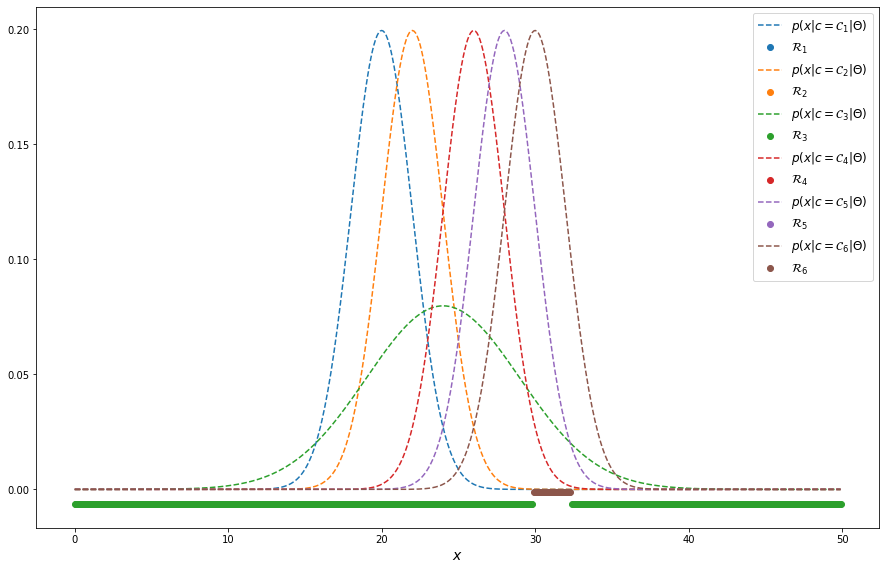

In [3]:
%matplotlib inline
#%matplotlib qt
from matplotlib import pyplot as plt
from ipywidgets import *

def figure(C, mu_0, pi_0, sigma_0, condjoin, marg):
    
    # data range
    xlim = [0, 50]
    mulim = [20, 30]
    x = np.arange(xlim[0],xlim[1], 0.1)

    # invent some generative parameters
    mu = np.linspace(mulim[0],mulim[1],C)
    #mu = np.array([20.]*C)
    sigma = np.array([2]*C)
    pi = np.array([(1-pi_0)/(C-1)]*C)
        
    # interactively adjust parameters of class c0
    middle = int(float(C)/2)
    mu[middle-1] = mu_0
    pi[middle-1] = pi_0
    sigma[middle-1] = sigma_0
    print("By adjusting the sliders, you can manipulate")
    print("the model parameters of class %d." % middle)
    print("For the other classes the parameters are set to")
    print("mu_c:")
    print(mu[np.arange(C)!=(middle-1)])
    print("sigma_c:"    )
    print(sigma[np.arange(C)!=(middle-1)])
    print("pi_c:"        )
    print(pi[np.arange(C)!=(middle-1)])
    
    # compute class-conditionals, marginals and posteriors
    p_x_c_ = p_x_c(x, mu, sigma)
    p_x_ = p_x(x, mu, sigma, pi)
    p_c_x_ = p_c_x(x, mu, sigma, pi)

    # visualization settings
    figsize = [6*3, 6*1.8]
    axesize = [0.29, 0.25, 0.65, 0.67]
    titlesize = 16
    legsize = 12
    labelsize = 14
    y_Rk = np.linspace(-0.01, -0.001, C)    
    ylim = [-0.5, np.amax(p_x_c_)*1.01]
        
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes(axesize)
    
    for c in range(C):
        col = "k"
        if c == (middle-1):
            col = "r"            
        
        if condjoin == 1:
            # plot conditionals
            lab = "$p(x|c=\mathcal{C}_{%d}|\Theta)$" % (c+1)    
            line = ax.plot(x, p_x_c_[:,c], '--', label=lab)#, color=col)
            linecolor = line[0].get_color()
        elif condjoin == 2:
            # plot joints
            lab = "$p(x,c=\mathcal{C}_{%d}|\Theta)$" % (c+1)    
            line = ax.plot(x, p_x_c_[:,c]*pi[c], '--', label=lab)#, color=col)
            linecolor = line[0].get_color()
            
        # plot decision regions
        lab = "$\mathcal{R}_{%d}$" % (c+1)            
        ind_Rk = (p_c_x_[:,c] > p_c_x_[:,np.arange(C)!=c].max(axis=1))
        Rk = x[ind_Rk]
        ax.plot(Rk, y_Rk[c]*np.ones_like(Rk), 'o', label=lab, color=linecolor)
                
        # uncomment to plot posterios
        #lab = "$p(c=C_{%d}\,|\,x,\Theta)$" % (c+1)
        #ax.plot(x, p_c_x_[:,c], label=lab, color=linecolor)
    
    if marg==1:
        # plot marginal
        lab = "$p(x\,|\,\Theta)$"
        ax.plot(x, p_x_, label=lab, color='black')

    ax.set_xlabel('$x$',fontsize=labelsize)
    #ax.set_title("Mixture of Gaussians",fontsize= titlesize)
    ax.legend(prop={'size': legsize});
#    ax.set_ylim(ylim)
    
    plt.show
    
interact(figure, C=(2,10,1), mu_0=(0, 50, 2), pi_0=(0.1,1,0.1), sigma_0=(1,10,1), condjoin=(1,2,1), marg=(0,1,1))